In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi

In [2]:
# Define the exact solution u = H
def exact_solution_u(x, t):
    return torch.sin(x)*torch.cos(t)

def initial_condition_u(x):
    return torch.sin(x) 

In [3]:
# Define the exact solution p = E
def exact_solution_p(x, t):
    return -torch.sin(t)*torch.cos(x)

def initial_condition_p(x):
    return 0.0*torch.sin(x) 

In [4]:
n_data = 1000
n_var = 2
data_inp = torch.zeros((n_data, n_var))
data_inp.shape
data_inp[:, 0] = pi/2
data_inp[:, 1] = torch.rand((n_data,1)).reshape(-1,)
data_inp

tensor([[1.5708, 0.8623],
        [1.5708, 0.4565],
        [1.5708, 0.2640],
        ...,
        [1.5708, 0.4434],
        [1.5708, 0.8425],
        [1.5708, 0.5869]])

In [5]:
u_data = exact_solution_u(data_inp[:, 0], data_inp[:, 1])
u_data = u_data.reshape(-1,1)

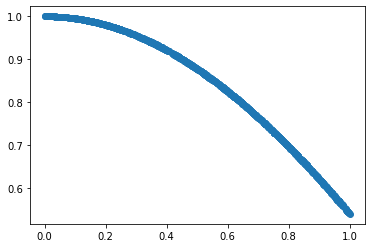

In [6]:
plt.scatter(data_inp[:, 1], u_data)

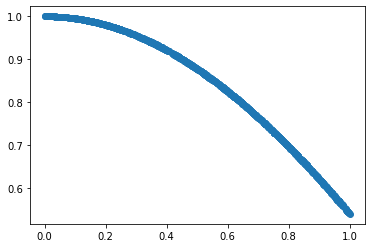

In [7]:
sigma=0.00
u_data = u_data*(1 + sigma*torch.randn(1000,1))
plt.scatter(data_inp[:, 1], u_data)

In [8]:
# assigning number of points
initial_pts = 200
left_boundary_pts = 200 
right_boundary_pts = 200
residual_pts = 1000

In [9]:
# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

manualSeed = 1

#np.random.seed(manualSeed)
#random.seed(manualSeed)
torch.manual_seed(manualSeed)

x_init = pi*torch.rand((initial_pts,1)) # initial pts
t_init = 0*x_init
init =  torch.cat([x_init, t_init],1)
u_init = initial_condition_u(init[:,0]).reshape(-1, 1)
p_init = initial_condition_p(init[:,0]).reshape(-1, 1)
w_init = torch.cat([u_init, p_init],1)



xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
tb_left = torch.rand((left_boundary_pts, 1)) # 
b_left = torch.cat([xb_left, tb_left ],1)
u_b_l = exact_solution_u(xb_left, tb_left)
p_b_l = exact_solution_p(xb_left, tb_left)
w_b_l = torch.cat([u_b_l, p_b_l],1)



xb_right = pi*torch.ones((right_boundary_pts, 1)) # right spatial boundary
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, tb_right ],1)
u_b_r = exact_solution_u(xb_right, tb_right)
p_b_r = exact_solution_p(xb_right, tb_right)
w_b_r = torch.cat([u_b_r, p_b_r],1)

x_interior = pi*torch.rand((residual_pts, 1))
t_interior = torch.rand((residual_pts, 1))
interior = torch.cat([x_interior, t_interior],1)





training_set = DataLoader(torch.utils.data.TensorDataset(init, w_init, b_left,  b_right), batch_size=200, shuffle=False)

In [10]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Tanh()
        
        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)


In [11]:
# Model definition
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = w_init.shape[1]+1, n_hidden_layers=4, neurons=20)


In [12]:
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization
init_xavier(my_network, retrain)
#print(my_network(init))

In [13]:
if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")

In [14]:
def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (initial, w_initial, bd_left,  bd_right) in enumerate(training_set):
            
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                initial.requires_grad = True
                w_initial_pred_ = model(initial)
                u_initial_pred_ = w_initial_pred_[:,0].reshape(-1,1)
                p_initial_pred_ = w_initial_pred_[:,1].reshape(-1,1)
                
                
                # with derivative
                inpu = torch.ones(initial_pts, 1 )
                
                grad_u_ini = torch.autograd.grad(u_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[0]
                
                u_initial_t = grad_u_ini[:, 1]
                
                
                grad_p_ini = torch.autograd.grad(p_initial_pred_, initial, grad_outputs=inpu, create_graph=True)[0]
                
                p_initial_t = grad_p_ini[:, 1]
                
                
                # for left boundary
                w_bd_left_pred_ = model(bd_left)
                u_bd_left_pred_ = w_bd_left_pred_[:,0].reshape(-1,1)
                p_bd_left_pred_ = w_bd_left_pred_[:,1].reshape(-1,1)
                # for right boundary
                w_bd_right_pred_ = model(bd_right)
                u_bd_right_pred_ = w_bd_right_pred_[:,0].reshape(-1,1)
                p_bd_right_pred_ = w_bd_right_pred_[:,1].reshape(-1,1)
                
                # residual calculation
                interior.requires_grad = True
                w_hat = model(interior)
                u_hat = w_hat[:,0].reshape(-1,1)
                p_hat = w_hat[:,1].reshape(-1,1)
                alpha = w_hat[:, 2].reshape(-1,1)
                inputs = torch.ones(residual_pts, 1 )
                inputs2 = torch.ones(residual_pts, 1)
                grad_u_hat = torch.autograd.grad(u_hat.reshape(-1,1), interior, grad_outputs=inputs, create_graph=True)[0]
                
                u_x = grad_u_hat[:, 0].reshape(-1,1)
                
               
                
                grad_p_hat = torch.autograd.grad(p_hat, interior, grad_outputs=inputs, create_graph=True)[0]
                
                p_x = grad_p_hat[:, 0].reshape(-1,1)
                
              
                
                
                
                #grad_grad_u_x = torch.autograd.grad(u_x, interior, grad_outputs=torch.ones(interior.shape[0]), create_graph=True)[0]
                #u_xx = grad_grad_u_x[:, 0]
                u_t = grad_u_hat[:, 1].reshape(-1,1)
                
               
                
                p_t = grad_p_hat[:,1].reshape(-1,1)
             
                
                
                output_data_pred_ = model(data_inp)
                u_data_pred_ = output_data_pred_[:, 0]
                
                
                
                
                # Item 1. below
                loss1 = torch.mean((u_initial_pred_.reshape(-1, ) - w_initial[:,0].reshape(-1, ))**p) + 0.1*torch.mean((u_t.reshape(-1, ) + p_x.reshape(-1, ))**p)+torch.mean((u_bd_left_pred_.reshape(-1,)- u_b_l.reshape(-1,))**p) + torch.mean((u_bd_right_pred_.reshape(-1,)- u_b_r.reshape(-1,))**p)
                loss2 = torch.mean((p_initial_pred_.reshape(-1, ) - w_initial[:,1].reshape(-1, ))**p)+ 0.1*torch.mean((alpha*p_t.reshape(-1, )  + u_x.reshape(-1, ) + torch.cos(interior[:, 0])*torch.cos(interior[:, 1]))**p)+torch.mean((p_bd_left_pred_.reshape(-1,) - p_b_l.reshape(-1,))**p) + torch.mean((p_bd_right_pred_.reshape(-1,)- p_b_r.reshape(-1,))**p)
                data = torch.mean((u_data_pred_.reshape(-1, ) - u_data.reshape(-1, ))**p)
                loss = loss1 + loss2 + data
                #loss = torch.max(torch.abs((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, )))) + torch.max(torch.abs((u_t.reshape(-1, ) - u_xx.reshape(-1, ))))+torch.max(torch.abs((u_bd_left_pred_.reshape(-1,)))) + torch.max(torch.abs((u_bd_right_pred_.reshape(-1,))))
 
                
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss
            
            # Item 3. below
            optimizer.step(closure=closure)
            
        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


In [15]:
n_epochs = 1500
history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )

################################  0  ################################
Loss:  6.648855686187744
################################  1  ################################
Loss:  6.441938400268555
################################  2  ################################
Loss:  5.391645908355713
################################  3  ################################
Loss:  4.476315975189209
################################  4  ################################
Loss:  3.8347389698028564
################################  5  ################################
Loss:  3.340365171432495
################################  6  ################################
Loss:  2.926802635192871
################################  7  ################################
Loss:  2.570324182510376
################################  8  ################################
Loss:  2.26119065284729
################################  9  ################################
Loss:  1.9943023920059204
################################  10  ###########

Loss:  0.007583233527839184
################################  88  ################################
Loss:  0.007201140280812979
################################  89  ################################
Loss:  0.006828914862126112
################################  90  ################################
Loss:  0.006476891227066517
################################  91  ################################
Loss:  0.006138427648693323
################################  92  ################################
Loss:  0.005823897197842598
################################  93  ################################
Loss:  0.005524710286408663
################################  94  ################################
Loss:  0.005247208755463362
################################  95  ################################
Loss:  0.004986467771232128
################################  96  ################################
Loss:  0.004738995339721441
################################  97  ################################
Loss:  0.0

Loss:  0.0005992100341245532
################################  173  ################################
Loss:  0.0005940180853940547
################################  174  ################################
Loss:  0.0005885999416932464
################################  175  ################################
Loss:  0.0005816222983412445
################################  176  ################################
Loss:  0.0005760567146353424
################################  177  ################################
Loss:  0.0005688144592568278
################################  178  ################################
Loss:  0.0005613278481177986
################################  179  ################################
Loss:  0.0005533277289941907
################################  180  ################################
Loss:  0.000544242502655834
################################  181  ################################
Loss:  0.0005350451683625579
################################  182  ########################

Loss:  0.00017124073929153383
################################  259  ################################
Loss:  0.00016948138363659382
################################  260  ################################
Loss:  0.0001677338732406497
################################  261  ################################
Loss:  0.00016599823720753193
################################  262  ################################
Loss:  0.0001643195137148723
################################  263  ################################
Loss:  0.0001626080193091184
################################  264  ################################
Loss:  0.0001609936443855986
################################  265  ################################
Loss:  0.00015944828919600695
################################  266  ################################
Loss:  0.00015801697736606002
################################  267  ################################
Loss:  0.00015664231614209712
################################  268  #################

Loss:  7.628231833223253e-05
################################  343  ################################
Loss:  7.600771641591564e-05
################################  344  ################################
Loss:  7.573700713692233e-05
################################  345  ################################
Loss:  7.546826964244246e-05
################################  346  ################################
Loss:  7.51978877815418e-05
################################  347  ################################
Loss:  7.492914301110432e-05
################################  348  ################################
Loss:  7.465711678378284e-05
################################  349  ################################
Loss:  7.439397450070828e-05
################################  350  ################################
Loss:  7.413443381665275e-05
################################  351  ################################
Loss:  7.38785311114043e-05
################################  352  #########################

Loss:  4.507829362410121e-05
################################  430  ################################
Loss:  4.484008968574926e-05
################################  431  ################################
Loss:  4.462292417883873e-05
################################  432  ################################
Loss:  4.442702993401326e-05
################################  433  ################################
Loss:  4.4249722122913226e-05
################################  434  ################################
Loss:  4.408775203046389e-05
################################  435  ################################
Loss:  4.393759081722237e-05
################################  436  ################################
Loss:  4.379840902402066e-05
################################  437  ################################
Loss:  4.366636858321726e-05
################################  438  ################################
Loss:  4.3548880057642236e-05
################################  439  #####################

Loss:  3.3768374123610556e-05
################################  513  ################################
Loss:  3.361055496498011e-05
################################  514  ################################
Loss:  3.34505493810866e-05
################################  515  ################################
Loss:  3.3294560125796124e-05
################################  516  ################################
Loss:  3.3149543014587834e-05
################################  517  ################################
Loss:  3.3011430787155405e-05
################################  518  ################################
Loss:  3.288053267169744e-05
################################  519  ################################
Loss:  3.2758896850282326e-05
################################  520  ################################
Loss:  3.264046972617507e-05
################################  521  ################################
Loss:  3.252264650654979e-05
################################  522  ###################

Loss:  2.3756227164994925e-05
################################  594  ################################
Loss:  2.3660113583900966e-05
################################  595  ################################
Loss:  2.358695746806916e-05
################################  596  ################################
Loss:  2.351256443944294e-05
################################  597  ################################
Loss:  2.343644700886216e-05
################################  598  ################################
Loss:  2.335956014576368e-05
################################  599  ################################
Loss:  2.328151822439395e-05
################################  600  ################################
Loss:  2.320314888493158e-05
################################  601  ################################
Loss:  2.3124874132918194e-05
################################  602  ################################
Loss:  2.3050279196468182e-05
################################  603  ###################

Loss:  1.8062542949337512e-05
################################  675  ################################
Loss:  1.8016484318650328e-05
################################  676  ################################
Loss:  1.7970945918932557e-05
################################  677  ################################
Loss:  1.7925072825164534e-05
################################  678  ################################
Loss:  1.788000372471288e-05
################################  679  ################################
Loss:  1.7837568520917557e-05
################################  680  ################################
Loss:  1.7796573956729844e-05
################################  681  ################################
Loss:  1.775545570126269e-05
################################  682  ################################
Loss:  1.771302049746737e-05
################################  683  ################################
Loss:  1.7674528862698935e-05
################################  684  ################

Loss:  1.5600031474605203e-05
################################  759  ################################
Loss:  1.556975803396199e-05
################################  760  ################################
Loss:  1.5545792848570272e-05
################################  761  ################################
Loss:  1.5519091903115623e-05
################################  762  ################################
Loss:  1.548674117657356e-05
################################  763  ################################
Loss:  1.545156010251958e-05
################################  764  ################################
Loss:  1.541550227557309e-05
################################  765  ################################
Loss:  1.5375235307146795e-05
################################  766  ################################
Loss:  1.533494287286885e-05
################################  767  ################################
Loss:  1.529501605546102e-05
################################  768  ###################

Loss:  1.3041156307735946e-05
################################  844  ################################
Loss:  1.3019322977925185e-05
################################  845  ################################
Loss:  1.2999574209970888e-05
################################  846  ################################
Loss:  1.2981272448087111e-05
################################  847  ################################
Loss:  1.296352729696082e-05
################################  848  ################################
Loss:  1.2947945833730046e-05
################################  849  ################################
Loss:  1.2932371646456886e-05
################################  850  ################################
Loss:  1.2918673746753484e-05
################################  851  ################################
Loss:  1.2905537914775778e-05
################################  852  ################################
Loss:  1.2892885024484713e-05
################################  853  ##############

Loss:  1.174391400127206e-05
################################  925  ################################
Loss:  1.172580505226506e-05
################################  926  ################################
Loss:  1.1707909834512975e-05
################################  927  ################################
Loss:  1.168965536635369e-05
################################  928  ################################
Loss:  1.1672053915390279e-05
################################  929  ################################
Loss:  1.165473076980561e-05
################################  930  ################################
Loss:  1.1638082469289657e-05
################################  931  ################################
Loss:  1.1622840247582644e-05
################################  932  ################################
Loss:  1.1607316992012784e-05
################################  933  ################################
Loss:  1.1592487680900376e-05
################################  934  #################

Loss:  1.0380117601016536e-05
################################  1007  ################################
Loss:  1.035929199133534e-05
################################  1008  ################################
Loss:  1.033458647725638e-05
################################  1009  ################################
Loss:  1.0308745913789608e-05
################################  1010  ################################
Loss:  1.0286014003213495e-05
################################  1011  ################################
Loss:  1.0262939213134814e-05
################################  1012  ################################
Loss:  1.023980166792171e-05
################################  1013  ################################
Loss:  1.021687603497412e-05
################################  1014  ################################
Loss:  1.0194403330388013e-05
################################  1015  ################################
Loss:  1.0171258509217296e-05
################################  1016  #######

Loss:  8.942904969444498e-06
################################  1091  ################################
Loss:  8.916126716940198e-06
################################  1092  ################################
Loss:  8.88683098310139e-06
################################  1093  ################################
Loss:  8.85713870957261e-06
################################  1094  ################################
Loss:  8.823723874229472e-06
################################  1095  ################################
Loss:  8.793049346422777e-06
################################  1096  ################################
Loss:  8.759977390582208e-06
################################  1097  ################################
Loss:  8.722918209969066e-06
################################  1098  ################################
Loss:  8.688304660608992e-06
################################  1099  ################################
Loss:  8.654268640384544e-06
################################  1100  ###############

Loss:  7.561799520772183e-06
################################  1177  ################################
Loss:  7.55310247768648e-06
################################  1178  ################################
Loss:  7.544914296886418e-06
################################  1179  ################################
Loss:  7.537121291534277e-06
################################  1180  ################################
Loss:  7.530038146796869e-06
################################  1181  ################################
Loss:  7.522944997617742e-06
################################  1182  ################################
Loss:  7.5165708040003665e-06
################################  1183  ################################
Loss:  7.510484465456102e-06
################################  1184  ################################
Loss:  7.503527740482241e-06
################################  1185  ################################
Loss:  7.497960723412689e-06
################################  1186  #############

Loss:  6.5488538893987425e-06
################################  1264  ################################
Loss:  6.543745257658884e-06
################################  1265  ################################
Loss:  6.538746220030589e-06
################################  1266  ################################
Loss:  6.5336894294887315e-06
################################  1267  ################################
Loss:  6.528569883812452e-06
################################  1268  ################################
Loss:  6.523416686832206e-06
################################  1269  ################################
Loss:  6.51804248263943e-06
################################  1270  ################################
Loss:  6.5126814661198296e-06
################################  1271  ################################
Loss:  6.507203579531051e-06
################################  1272  ################################
Loss:  6.50156016490655e-06
################################  1273  ############

Loss:  5.957010216661729e-06
################################  1346  ################################
Loss:  5.944189979345538e-06
################################  1347  ################################
Loss:  5.932968633715063e-06
################################  1348  ################################
Loss:  5.9224712458672e-06
################################  1349  ################################
Loss:  5.911844255024334e-06
################################  1350  ################################
Loss:  5.90180297876941e-06
################################  1351  ################################
Loss:  5.891795808565803e-06
################################  1352  ################################
Loss:  5.882782261323882e-06
################################  1353  ################################
Loss:  5.873415830137674e-06
################################  1354  ################################
Loss:  5.8643568081606645e-06
################################  1355  ###############

Loss:  5.310798769642133e-06
################################  1434  ################################
Loss:  5.3049943744554184e-06
################################  1435  ################################
Loss:  5.299495569488499e-06
################################  1436  ################################
Loss:  5.293897629599087e-06
################################  1437  ################################
Loss:  5.287878138915403e-06
################################  1438  ################################
Loss:  5.282061465550214e-06
################################  1439  ################################
Loss:  5.276848241919652e-06
################################  1440  ################################
Loss:  5.2721266001753975e-06
################################  1441  ################################
Loss:  5.267396772978827e-06
################################  1442  ################################
Loss:  5.262776994641172e-06
################################  1443  ###########

In [16]:
# saving and loading Model
FILE = "maxwell1D_1_inverse_run5.pth"
torch.save(my_network, FILE)  # comment this

# uncomment below when you need to test for different points
#my_network = torch.load(FILE)
#my_network.eval()

In [17]:
x_test = torch.linspace(0, pi, 10000).reshape(-1,1)
t_test = torch.ones((10000,1))
test = torch.cat([x_test, t_test],1)
u_test = exact_solution_u(x_test, t_test).reshape(-1,1)
p_test = exact_solution_p(x_test, t_test).reshape(-1,1)
w_test_pred = my_network(test)
u_test_pred = w_test_pred[:,0].reshape(-1,1)
p_test_pred = w_test_pred[:,1].reshape(-1,1)

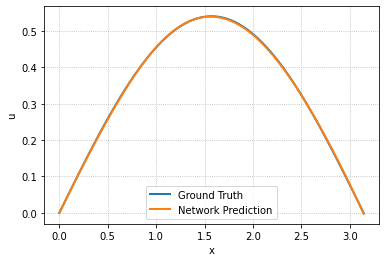

In [18]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, u_test, label="Ground Truth",lw=2)
plt.plot(x_test, u_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [19]:
print(torch.mean(w_test_pred[:,2]))

tensor(1.9990, grad_fn=<MeanBackward0>)


In [20]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.0014798527445236687 %


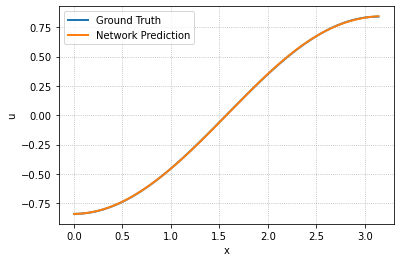

In [21]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, p_test, label="Ground Truth",lw=2)
plt.plot(x_test, p_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [22]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((p_test_pred - p_test)**2)/torch.mean(p_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.0006192856289999327 %


In [23]:
# for ploting

In [24]:
model = my_network
x_test = pi*torch.rand(100000).reshape(-1,1)
t_test = torch.rand(100000).reshape(-1,1)
test = torch.cat([x_test, t_test],1)
u_test = exact_solution_u(x_test,t_test).reshape(-1,1)
p_test = exact_solution_p(x_test,t_test).reshape(-1,1)
u_test_pred = my_network(test)
u_pred = u_test_pred[:, 0].reshape(-1,1)
p_pred = u_test_pred[:, 1].reshape(-1,1)


relative_error_u = torch.abs(u_pred- u_test)
relative_error_p = torch.abs(p_pred- p_test)

x_test = x_test.detach().numpy()
t_test = t_test.detach().numpy()
u_pred = u_pred.detach().numpy()
p_pred = p_pred.detach().numpy()
relative_error_u = relative_error_u.detach().numpy()
relative_error_p = relative_error_p.detach().numpy()


x_test = x_test.reshape(-1,)
t_test = t_test.reshape(-1,)

u_pred = u_pred.reshape(-1,)
p_pred = p_pred.reshape(-1,)

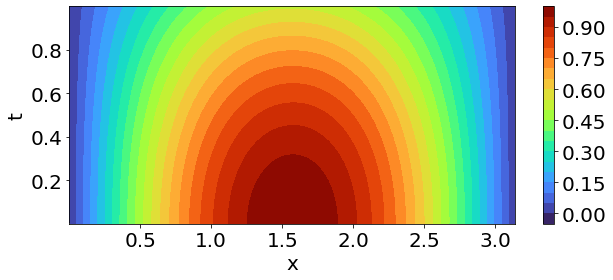

In [25]:
plt.rcParams['figure.figsize'] = [10, 4]


CS = plt.tricontourf(x_test, t_test, u_pred, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.savefig('Results/oned/exp1/H_pred.png', dpi = 300, bbox_inches = "tight")

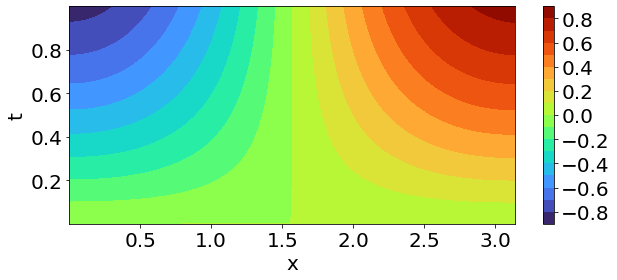

In [26]:
CS = plt.tricontourf(x_test, t_test, p_pred, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('Results/oned/exp1/E_pred.png', dpi = 300, bbox_inches = "tight")

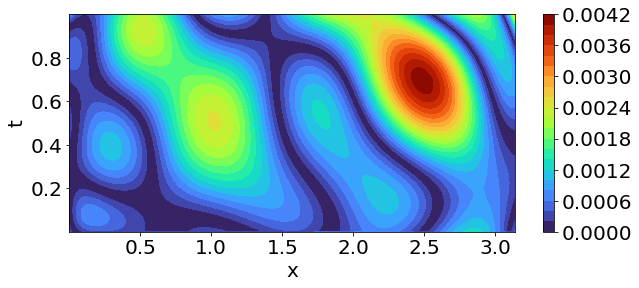

In [27]:
x_test = x_test.reshape(-1, )
t_test = t_test.reshape(-1, )
relative_error_u = relative_error_u.reshape(-1,)

CS = plt.tricontourf(x_test, t_test, relative_error_u, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('Results/oned/exp1/relative_error_H.png', dpi = 300, bbox_inches = "tight")

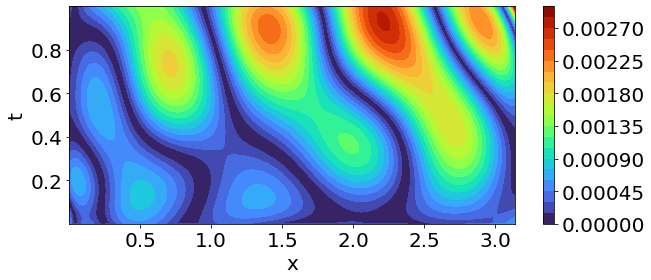

In [28]:
relative_error_p = relative_error_p.reshape(-1,)

CS = plt.tricontourf(x_test, t_test, relative_error_p, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('Results/oned/exp1/relative_error_E.png', dpi = 300, bbox_inches = "tight")

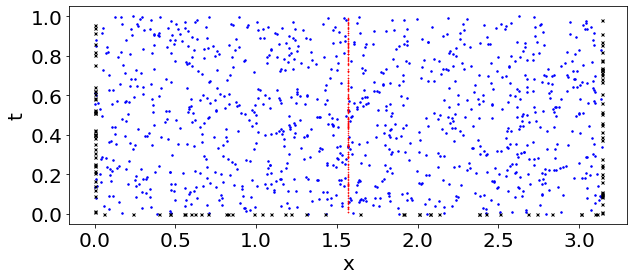

In [29]:
#x_interior = pi*torch.rand((residual_pts, 1))
#t_interior = torch.rand((residual_pts, 1))
#interior = torch.cat([x_interior, t_interior],1)

data_x = data_inp[:, 0]
data_t = data_inp[:, 1]

plt.plot(x_interior, t_interior, 'bo', ms=1.5)

#x_init = pi*torch.rand((initial_pts,1)) 
#t_init = 0*x_init
plt.plot(x_init[::5], t_init[::5], "kx", ms=3)

plt.plot(data_x[::5], data_t[::5], 'ro', ms=0.5)

#xb_left = torch.zeros((left_boundary_pts, 2)) # left spatial boundary
#tb_left = torch.rand((left_boundary_pts, 2)) #
plt.plot(xb_left[::5], tb_left[::5], "kx", ms=3)

#xb_right = pi*torch.ones((right_boundary_pts, 1)) # right spatial boundary
#tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
plt.plot(xb_right[::5], tb_right[::5], "kx", ms=3)

plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('Results/oned/exp1/data_pts.png', dpi = 300, bbox_inches = "tight")
plt.show()